In [1]:
import os, sys
import time
import json

import matplotlib.pyplot as plt

import bz2

import msgpack

import xgboost as xgb
from time import time

import tempfile

In [7]:
def encoding_vs_compression(model_folder, compression_func):
    compression_rates = {"bz2": [], "compressed": [], "bz2+compressed": []}

    for model_file in os.listdir(model_folder):
        model_path = os.path.join(model_folder, model_file)
        with open(model_path, "r") as f:
            model_json = json.load(f)

        with open(model_path, "rb") as f:
            model_binary = f.read()

        original_size = os.path.getsize(model_path)

        # bz2
        writer = DataFileWriter(open("model.bz2", "wb"), DatumWriter(), bz2_schema)
        writer.append(model_json)
        writer.close()
        bz2_size = os.path.getsize("model.bz2")

        # Compression
        compressed_model = compression_func(model_binary)
        with open("model.bin", "wb") as f:
            f.write(compressed_model)
        compressed_size = os.path.getsize("model.bin")

        # Compression + bz2
        with open("model.bin", "rb") as f:
            bz2_binary = f.read()
        compressed_bz2 = compression_func(bz2_binary)
        with open("model_bz2_compressed.bin", "wb") as f:
            f.write(compressed_bz2)
        compressed_bz2_size = os.path.getsize("model_bz2_compressed.bin")

        os.remove("model.bz2")
        os.remove("model_bz2_compressed.bin")
        os.remove("model.bin")

        bz2_ratio = original_size / bz2_size
        compressed_ratio = original_size / compressed_size
        compressed_bz2_ratio = original_size / compressed_bz2_size

        compression_rates["bz2"].append(bz2_ratio)
        compression_rates["compressed"].append(compressed_ratio)
        compression_rates["bz2+compressed"].append(compressed_bz2_ratio)

    for key, rates in compression_rates.items():
        compression_rates[key] = sum(rates) / len(rates)

    return compression_rates

In [2]:
import xgboost as xgb
from time import time
import math


def mean_and_std(data):
    # Calculate mean
    mean = sum(data) / len(data)

    # Calculate standard deviation
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = math.sqrt(variance)

    return mean, std_dev

In [3]:
xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost"

daily_path = xgboost_path + "/daily"
daily_100 = daily_path + "/100trees"
daily_1000 = daily_path + "/1000trees"
daily_10000 = daily_path + "/10000trees"

In [4]:
def load_model_json(model_path):
    booster = xgb.Booster()
    booster.load_model(model_path)
    return booster


def save_model_json(booster, model_path):
    booster.save_model(model_path)

In [5]:
def save_model_compressed(booster, model_path, compression_func):
    temp_model_path = tempfile.mktemp(suffix=".json")
    booster.save_model(temp_model_path)

    # Read the JSON data from the temporary file
    with open(temp_model_path, "rb") as f:
        model_binary = f.read()

    # Compress byte stream
    compressed = compression_func(model_binary)

    # Write compressed data to a file
    with open(model_path, "wb") as outfile:
        outfile.write(compressed)


def load_model_compressed(model_path, decompression_func):
    # Read and unpack the MessagePack data
    with open(model_path, "rb") as f:
        packed_data = f.read()
    model = decompression_func(packed_data)

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp(suffix=".json")
    with open(temp_model_path, "wb") as f:
        f.write(model)
    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [6]:
def save_model_msgpack(booster, model_path_msgpack):
    temp_model_path = tempfile.mktemp(suffix=".json")
    booster.save_model(temp_model_path)

    # Read the JSON data from the temporary file
    with open(temp_model_path, "r") as f:
        model_json = json.load(f)

    # Pack the byte stream using MessagePack
    packed = msgpack.packb(model_json)

    # Write the packed data to a file
    with open(model_path_msgpack, "wb") as outfile:
        outfile.write(packed)


def load_model_msgpack(model_path_msgpack):
    # Read and unpack the MessagePack data
    with open(model_path_msgpack, "rb") as f:
        packed_data = f.read()
    model_dict = msgpack.unpackb(packed_data)

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp()
    with open(temp_model_path, "w") as f:
        json.dump(model_dict, f)

    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [7]:
def save_model_msgpack_bz2(booster, model_path, compression_func):
    # 1st encode as msgpack
    temp_model_path = tempfile.mktemp(suffix=".json")
    booster.save_model(temp_model_path)
    # Read the JSON data from the temporary file
    with open(temp_model_path, "r") as f:
        model_dict = json.load(f)

    # Pack the byte stream using MessagePack
    packed = msgpack.packb(model_dict)

    # 2nd compress packed
    compressed_packed = compression_func(packed)
    with open(model_path, "wb") as outfile:
        outfile.write(compressed_packed)


def load_model_msgpack_bz2(model_path, decompression_func):
    with open(model_path, "rb") as infile:
        compressed_packed = infile.read()

    # 1st decompressed
    packed = decompression_func(compressed_packed)

    # 2nd unpack
    model_dict = msgpack.unpackb(packed)

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp()
    with open(temp_model_path, "w") as f:
        json.dump(model_dict, f)

    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [8]:
def get_metrics(model_dir):
    dt_json_load = []
    dt_json_save = []
    json_sizes = []

    dt_msgpack_load = []
    dt_msgpack_save = []
    msgpack_sizes = []

    dt_bz2_load = []
    dt_bz2_save = []
    bz2_sizes = []

    dt_msgpackbz2_load = []
    dt_msgpackbz2_save = []
    msgpackbz2_sizes = []

    for model_file in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_file)

        # JSON
        # Load
        t0 = time()
        booster = load_model_json(model_path)
        dt_json_load.append(time() - t0)
        # Save
        t0 = time()
        save_model_json(booster, model_path)
        dt_json_save.append(time() - t0)
        # Size
        json_size = os.path.getsize(model_path)
        json_sizes.append(1)

        # MSGPACK
        msgpack_path = "test.msgpack"
        # Save
        t0 = time()
        save_model_msgpack(booster, msgpack_path)
        dt_msgpack_save.append(time() - t0)
        # # Load
        t0 = time()
        msgpack_booster = load_model_msgpack(msgpack_path)
        dt_msgpack_load.append(time() - t0)
        # Size
        msgpack_sizes.append(json_size / os.path.getsize(msgpack_path))

        # Bz2
        # Save
        bz2_path = "bz2.bin"
        t0 = time()
        save_model_compressed(booster, bz2_path, bz2.compress)
        dt_bz2_save.append(time() - t0)
        # Load
        t0 = time()
        bz2_booster = load_model_compressed(bz2_path, bz2.decompress)
        dt_bz2_load.append(time() - t0)
        # Size
        bz2_sizes.append(json_size / os.path.getsize(bz2_path))

        # MsgPack + BZ2
        msgpack_bz2_path = "msgpack_bz2.bin"
        # Save
        t0 = time()
        save_model_msgpack_bz2(booster, msgpack_bz2_path, bz2.compress)
        dt_msgpackbz2_save.append(time() - t0)
        # Load
        t0 = time()
        msgpack_bz2_booster = load_model_msgpack_bz2(msgpack_bz2_path, bz2.decompress)
        dt_msgpackbz2_load.append(time() - t0)
        # Size
        msgpackbz2_sizes.append(json_size / os.path.getsize(msgpack_bz2_path))

        os.remove(msgpack_path)
        os.remove(bz2_path)
        os.remove(msgpack_bz2_path)

        assert (
            booster.get_dump()
            == bz2_booster.get_dump()
            == msgpack_booster.get_dump()
            == msgpack_bz2_booster.get_dump()
        )

        # Evaluation
    # Load
    json_mean, json_std = mean_and_std(dt_json_load)
    bz2_mean, bz2_std = mean_and_std(dt_bz2_load)
    msgpack_mean, msgpack_std = mean_and_std(dt_msgpack_load)
    msgpack_bz2_mean, msgpack_bz2_std = mean_and_std(dt_msgpackbz2_load)
    dt_load = {
        "JSON": {"mean": json_mean, "std": json_std},
        "bz2": {"mean": bz2_mean, "std": bz2_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
        "bz2+MsgPack": {"mean": msgpack_bz2_mean, "std": msgpack_bz2_std},
    }
    # Save
    json_mean, json_std = mean_and_std(dt_json_save)
    bz2_mean, bz2_std = mean_and_std(dt_bz2_save)
    msgpack_mean, msgpack_std = mean_and_std(dt_msgpack_save)
    msgpack_bz2_mean, msgpack_bz2_std = mean_and_std(dt_msgpackbz2_save)
    dt_save = {
        "JSON": {"mean": json_mean, "std": json_std},
        "bz2": {"mean": bz2_mean, "std": bz2_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
        "bz2+MsgPack": {"mean": msgpack_bz2_mean, "std": msgpack_bz2_std},
    }

    # Size
    json_mean, json_std = mean_and_std(json_sizes)
    bz2_mean, bz2_std = mean_and_std(bz2_sizes)
    msgpack_mean, msgpack_std = mean_and_std(msgpack_sizes)
    msgpack_bz2_mean, msgpack_bz2_std = mean_and_std(msgpackbz2_sizes)
    sizes = {
        "JSON": {"mean": json_mean, "std": json_std},
        "bz2": {"mean": bz2_mean, "std": bz2_std},
        "MsgPack": {"mean": msgpack_mean, "std": msgpack_std},
        "bz2+MsgPack": {"mean": msgpack_bz2_mean, "std": msgpack_bz2_std},
    }

    return sizes, dt_save, dt_load

In [9]:
sizes_100, save_100, load_100 = get_metrics(daily_100)

In [11]:
sizes_1000, save_1000, load_1000 = get_metrics(daily_1000)

In [14]:
sizes_10000, save_10000, load_10000 = get_metrics(daily_10000)

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def plot(sample1, sample2, sample3, ylabel, title):
    # Organizing the data
    means_json = [
        sample1["JSON"]["mean"],
        sample2["JSON"]["mean"],
        sample3["JSON"]["mean"],
    ]
    stds_json = [sample1["JSON"]["std"], sample2["JSON"]["std"], sample3["JSON"]["std"]]

    means_bz2 = [
        sample1["bz2"]["mean"],
        sample2["bz2"]["mean"],
        sample3["bz2"]["mean"],
    ]
    stds_bz2 = [sample1["bz2"]["std"], sample2["bz2"]["std"], sample3["bz2"]["std"]]

    means_msgpack = [
        sample1["MsgPack"]["mean"],
        sample2["MsgPack"]["mean"],
        sample3["MsgPack"]["mean"],
    ]
    stds_msgpack = [
        sample1["MsgPack"]["std"],
        sample2["MsgPack"]["std"],
        sample3["MsgPack"]["std"],
    ]

    means_bz2msgpack = [
        sample1["bz2+MsgPack"]["mean"],
        sample2["bz2+MsgPack"]["mean"],
        sample3["bz2+MsgPack"]["mean"],
    ]
    stds_bz2msgpack = [
        sample1["bz2+MsgPack"]["std"],
        sample2["bz2+MsgPack"]["std"],
        sample3["bz2+MsgPack"]["std"],
    ]

    # Sample labels
    labels = ["100 Trees", "1000 Trees", "10000 Trees"]

    # Setting the positions of the bars
    x = np.arange(len(labels))  # the sample locations
    width = 0.2  # the width of the bars

    # Creating the plot
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, means_json, width, yerr=stds_json, label="JSON")
    rects2 = ax.bar(x, means_msgpack, width, yerr=stds_msgpack, label="MsgPack")
    rects3 = ax.bar(x + width, means_bz2, width, yerr=stds_bz2, label="bz2")
    rects4 = ax.bar(
        x + (width * 2),
        means_bz2msgpack,
        width,
        yerr=stds_bz2msgpack,
        label="bz2+MsgPack",
    )

    # Adding some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to attach a text label above each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    # Attaching the labels
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    # Showing the plot
    plt.tight_layout()
    plt.show()

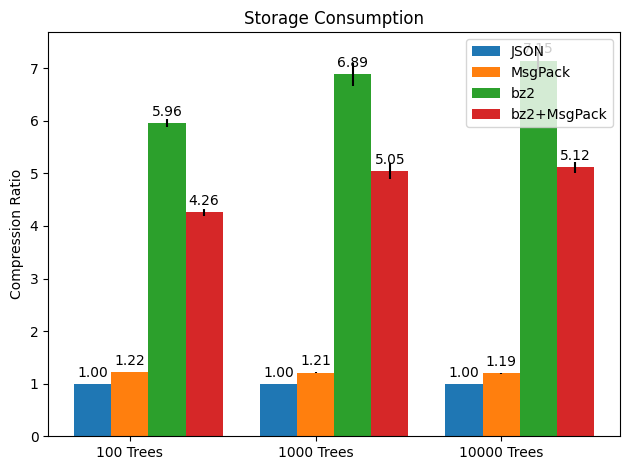

In [24]:
plot(
    sizes_100,
    sizes_1000,
    sizes_10000,
    ylabel="Compression Ratio",
    title="Storage Consumption",
)

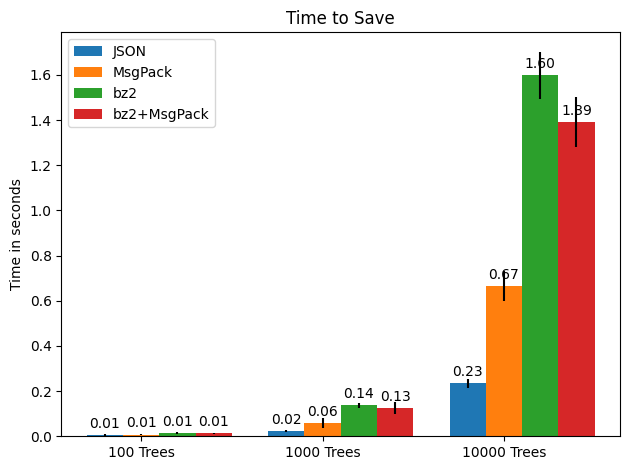

In [25]:
plot(save_100, save_1000, save_10000, ylabel="Time in seconds", title="Time to Save")

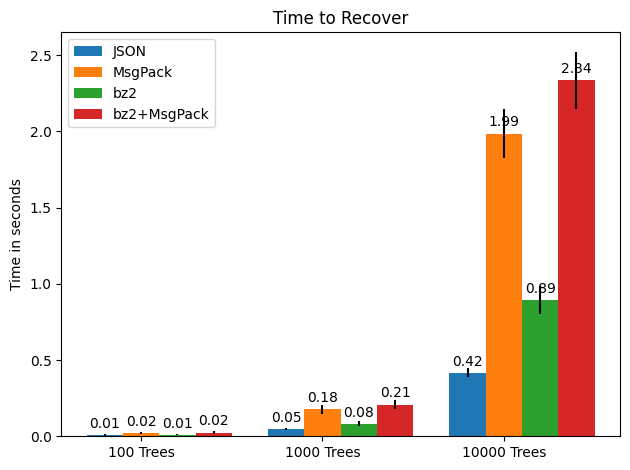

In [26]:
plot(load_100, load_1000, load_10000, ylabel="Time in seconds", title="Time to Recover")